In [3]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils as utils, util as wavelet
import matplotlib.pyplot as plt
import pandas as pd
from utils import constants as cnst, u_grid, u_interpolate as u_int
import glob
import ccores

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
def time_to_imergMin(h,mins):
    return str(h*60+mins).zfill(4)

In [364]:
idate = '20230527'# '20230523' 20:30
hour = 9
mins = 0
msg_time = pd.to_datetime('2000-01-01'+' '+str(hour)+':'+str(mins))#+pd.Timedelta('15min')
#tag = 'MFG'
tag = 'MSG'
msgfile = sorted(glob.glob(cnst.other_drive + '/nflics/core_rainfall_test/IR_108_BT_202305/IR_108_BT_'+idate+'_'+str(hour).zfill(2)+str(mins).zfill(2)+'.nc'))[0]
rainAIfile = sorted(glob.glob(cnst.other_drive + '/nflics/rainoverafricaAI/2023/05/MSG3'+idate+'-S*-E'+str(hour).zfill(2)+str(mins).zfill(2)+'.nc'))[0]
#GPM_DPR = glob.glob(cnst.other_drive + '/nflics/core_rainfall_test/GPM_DPR_GMI_L2B_v7/2B.GPM*.'+idate+)
IMERG_lateRunfile = sorted(glob.glob(cnst.other_drive + '/nflics/core_rainfall_test/IMERG_lateRun_L3v6/3B-HHR*.'+idate+'-S*.'+time_to_imergMin(hour,mins)+'.V06*.nc4'))[0]

In [365]:
box = [-18,30,4,26]

In [366]:
# msgdata = xr.open_mfdataset(msgfile, decode_times=False, concat_dim='time', combine='nested')
# dates = pd.date_range(idate, periods=msgdata.time.size, freq="15min")
# msgdata = msgdata.assign_coords(time=dates)
# msgdata 

In [367]:
# rainA = xr.open_mfdataset(rainAIfile, concat_dim='time', combine='nested').sel(latitude=slice(4,26), longitude=slice(-18,25))
# dates = pd.date_range(idate, periods=rainA.time.size, freq="15min")#+pd.Timedelta('15min')
# rainA = rainA.assign_coords(time=dates)

In [368]:
print(msgfile)
print(rainAIfile)
print(IMERG_lateRunfile)

/media/ck/LStorage/global_water/other//nflics/core_rainfall_test/IR_108_BT_202305/IR_108_BT_20230527_0900.nc
/media/ck/LStorage/global_water/other//nflics/rainoverafricaAI/2023/05/MSG320230527-S0845-E0900.nc
/media/ck/LStorage/global_water/other//nflics/core_rainfall_test/IMERG_lateRun_L3v6/3B-HHR-L.MS.MRG.3IMERG.20230527-S090000-E092959.0540.V06C.HDF5.nc4


In [369]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.top_labels = False   ## labels off
    xl.right_labels = False
    plt.title(title)
    # Countries
 #   ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

In [370]:
msg = xr.open_dataset(msgfile).squeeze()
rainA = xr.open_dataset(rainAIfile).sel(latitude=slice(4,26), longitude=slice(-18,30)).squeeze()
imerg = xr.open_dataset(IMERG_lateRunfile).sel(lat=slice(4,26), lon=slice(-18,30)).squeeze()

In [371]:
msg.lat_2d.max()

<xarray.DataArray 'lat_2d' ()>
array(20.92072487)
Coordinates:
    time     datetime64[ns] 2023-05-02T09:00:00

In [372]:
posi = np.where(imerg['HQprecipitation'].T.values>1)

In [373]:
ilats = imerg.lat[posi[0]]
ilons = imerg.lon[posi[1]]

In [374]:
# data_resolution = 5 # in km
# # make salem grid
# grid5k = u_grid.make(np.arange(box[0],box[1]), np.arange(box[2],box[3]), data_resolution*1000)
# dlon =  msg.lon_2d.values
# dlat = msg.lat_2d.values
# inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid5k)

In [375]:
data_test = msg['IR108_BT'].squeeze().values
try:
    data5k = u_int.interpolate_data(data_test, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lonN, latN = grid5k.ll_coordinates

In [376]:
outt, nogood, t_thresh_size, t_thresh_cut, pix_nb, area_img = utils.filter_img(data5k, 5)
wav = wavelet.waveletT(outt, dataset='METEOSAT5K_vera')

outmin -92.61275560524416 51.38664204624641


In [377]:
power_msg = utils.find_scales_dominant(wav, nogood, area_img, dataset='MSG')

In [378]:
# box = [-11,-4,5.5,10]
# f=plt.figure(figsize=(15,5), dpi=200)  # this opens a plot window
# ax = f.add_subplot(121, projection=ccrs.PlateCarree())  # this opens a new plot axis
# #draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
# tmin = -90
# tmax = 50
# draw_map(ax, msg['IR108_BT'], msg.lon_2d, msg.lat_2d, cmap='jet', levels=np.arange(tmin,tmax,2))
# ax.contour(rainA.longitude, rainA.latitude,  rainA['posterior_mean'], levels=[-1,1,5,10,30], cmap='Reds', linewidths=1)
# ax.contour(lonN, latN,  power_msg, levels=[-1,1,5,10,30], cmap='Blues', linewidths=1)
# ax.set_ylim(box[2], box[3])
# ax.set_xlim(box[0],box[1])
# ax.set_title('rainoverAI')

# ax = f.add_subplot(122, projection=ccrs.PlateCarree())  # this opens a new plot axis
# draw_map(ax, msg['IR108_BT'], msg.lon_2d, msg.lat_2d, cmap='jet', levels=np.arange(tmin,tmax,2))
# ax.contour(imerg.lon, imerg.lat,  imerg['HQprecipitation'].T, levels=[-1,1,10,20], cmap='Reds', linewidths=1)
# ax.contour(lonN, latN,  power_msg, levels=[-1,1,5,10,30], cmap='Blues', linewidths=1)
# ax.set_ylim(box[2], box[3])
# ax.set_xlim(box[0],box[1])
# ax.set_title('imerg')

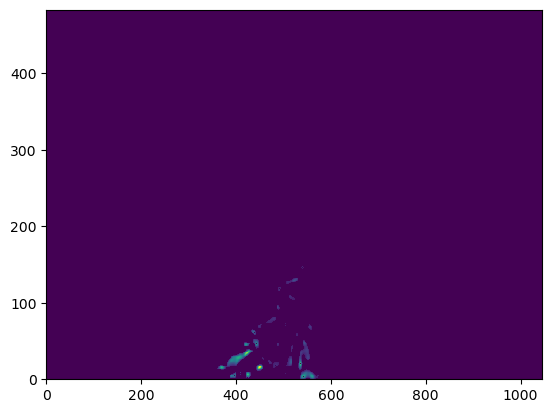

In [379]:
plt.pcolormesh(power_msg, vmin=0)

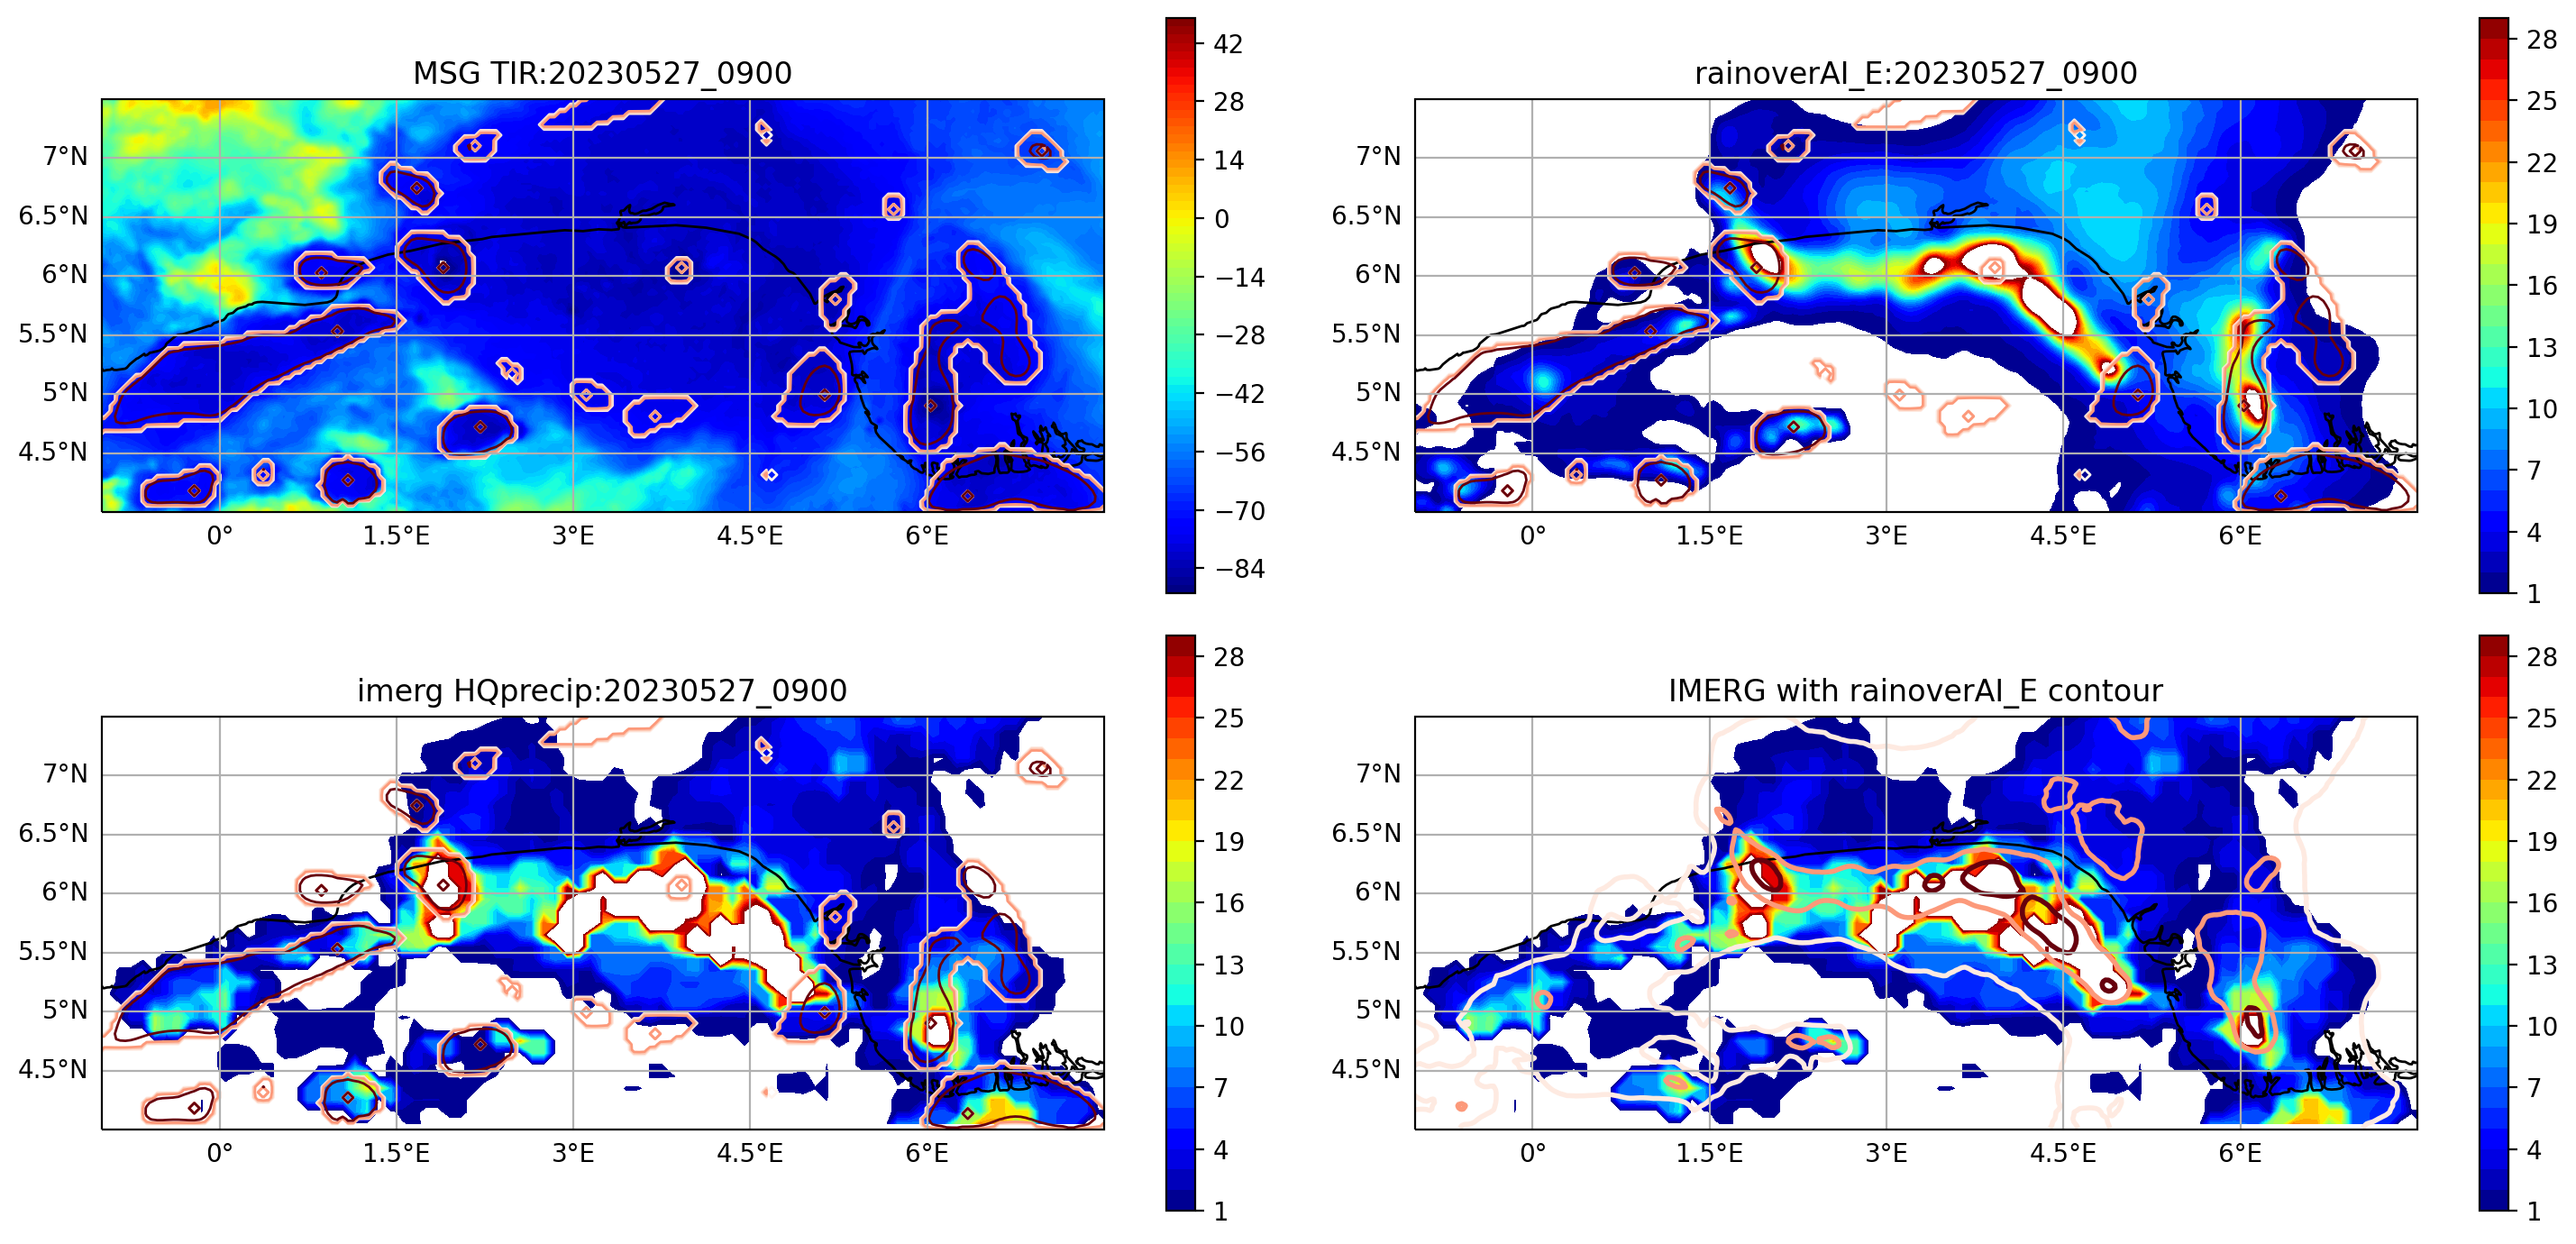

In [381]:
box = [-1,7.5,4,7.5]
f=plt.figure(figsize=(15,7), dpi=200)  # this opens a plot window

ax = f.add_subplot(221, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
tmin = -90
tmax = 50
draw_map(ax, msg['IR108_BT'], msg.lon_2d, msg.lat_2d, cmap='jet', levels=np.arange(tmin,tmax,2))
#draw_map(ax, rainA['posterior_mean'], rainA.longitude, rainA.latitude, levels=np.arange(1,30,1), cmap='jet')
#ax.contour(rainA.longitude, rainA.latitude,  rainA['posterior_mean'], levels=[-1,1,5,10,30], cmap='Reds', linewidths=1)
ax.contour(lonN, latN,  power_msg, levels=[-1,1,5,10,30], cmap='Reds', linewidths=1)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('MSG TIR:'+idate+'_'+str(hour).zfill(2)+str(mins).zfill(2))


ax = f.add_subplot(222, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
tmin = -90
tmax = 50
#draw_map(ax, msg['IR108_BT'], msg.lon_2d, msg.lat_2d, cmap='jet', levels=np.arange(tmin,tmax,2))
draw_map(ax, rainA['posterior_mean'], rainA.longitude, rainA.latitude, levels=np.arange(1,30,1), cmap='jet')
#ax.contour(rainA.longitude, rainA.latitude,  rainA['posterior_mean'], levels=[-1,1,5,10,30], cmap='Reds', linewidths=1)
ax.contour(lonN, latN,  power_msg, levels=[-1,1,5,10,30], cmap='Reds', linewidths=1)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('rainoverAI_E:'+idate+'_'+str(hour).zfill(2)+str(mins).zfill(2))

ax = f.add_subplot(223, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax,imerg['HQprecipitation'].T, imerg.lon, imerg.lat, levels=np.arange(1,30,1), cmap='jet')
ax.contour(lonN, latN,  power_msg, levels=[-1,1,5,10,30], cmap='Reds', linewidths=1)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('imerg HQprecip:'+idate+'_'+str(hour).zfill(2)+str(mins).zfill(2))

ax = f.add_subplot(224, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
tmin = -90
tmax = 50
#draw_map(ax, msg['IR108_BT'], msg.lon_2d, msg.lat_2d, cmap='jet', levels=np.arange(tmin,tmax,2))
#draw_map(ax, rainA['posterior_mean'], rainA.longitude, rainA.latitude, levels=np.arange(1,30,1), cmap='jet')
draw_map(ax,imerg['HQprecipitation'].T, imerg.lon, imerg.lat, levels=np.arange(1,30,1), cmap='jet')
ax.contour(rainA.longitude, rainA.latitude,  rainA['posterior_mean'], levels=[-1,1,10,30], cmap='Reds', linewidths=2)
#ax.contour(imerg.lon, imerg.lat,  imerg['HQprecipitation'].T, levels=[-1,1,5,10,30], cmap='Reds', linewidths=1)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('IMERG with rainoverAI_E contour')


plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/ncint_test/comparison/'+idate+'_'+str(hour).zfill(2)+str(mins).zfill(2)+'.jpg')